In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pyensembl import Genome
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests
%matplotlib inline

In [2]:
genome = Genome(reference_name='GRCh38',
                annotation_name='my_genome_features',
                gtf_path_or_url='/data03/christopher/annotations/Homo_sapiens.GRCh38.91.chr_patch_hapl_scaff.gtf',
                transcript_fasta_paths_or_urls='/data03/christopher/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa')
chrsm_annot_dir = "/data03/christopher/annotations/chrsm_annot.txt"
chr_map = {}
with open(chrsm_annot_dir) as f:
    for line in f:
        ensembl, ucsc = line.strip("\n").split("\t")
        chr_map[ensembl] = ucsc
        
m6ace = pd.read_table("/data03/christopher/annotations/m6ACE_HCT116.txt", header=None)
m6ace = m6ace.rename({0: 'chr', 2: 'genomic_position'}, axis=1)
m6ace["m6ace_modification_status"] = np.ones(len(m6ace))

inference = pd.read_csv("/home/christopher/inference_combined.csv")

In [3]:
read_columns = [x for x in inference.columns if "n_reads" in x]
inference = inference[np.any(inference[read_columns] >= 100, axis=1)].reset_index(drop=True)

In [4]:
inference

,transcript_id,transcript_position,n_reads_GIS_A549_directRNA_Rep5-Run1,probability_modified_GIS_A549_directRNA_Rep5-Run1,n_reads_GIS_A549_directRNA_Rep6-Run1,probability_modified_GIS_A549_directRNA_Rep6-Run1,n_reads_GIS_Hct116_directRNA_Rep2-Run1,probability_modified_GIS_Hct116_directRNA_Rep2-Run1,n_reads_GIS_Hct116_directRNA_Rep2-Run4,probability_modified_GIS_Hct116_directRNA_Rep2-Run4,...,n_reads_GIS_K562_directRNA_Rep4-Run1,probability_modified_GIS_K562_directRNA_Rep4-Run1,n_reads_GIS_K562_directRNA_Rep5-Run1,probability_modified_GIS_K562_directRNA_Rep5-Run1,n_reads_GIS_K562_directRNA_Rep6-Run1,probability_modified_GIS_K562_directRNA_Rep6-Run1,n_reads_GIS_MCF7_directRNA_Rep3-Run1,probability_modified_GIS_MCF7_directRNA_Rep3-Run1,n_reads_GIS_MCF7_directRNA_Rep4-Run1,probability_modified_GIS_MCF7_directRNA_Rep4-Run1
0,ENST00000000233,244,43.0,4.659944e-08,79.0,3.093089e-10,185.0,9.270614e-08,157.0,6.911035e-05,...,89.0,8.604845e-11,73.0,3.773470e-10,89.0,3.545131e-07,177.0,4.904297e-10,202.0,1.114243e-05
1,ENST00000000233,261,46.0,4.739738e-05,81.0,9.128710e-07,172.0,8.646264e-05,157.0,2.978807e-06,...,89.0,2.061076e-08,73.0,2.539302e-05,84.0,1.146691e-01,171.0,1.826766e-01,202.0,5.692012e-07
2,ENST00000000233,316,48.0,7.523650e-10,80.0,1.898714e-10,185.0,2.529082e-09,163.0,1.172920e-08,...,99.0,1.046194e-07,85.0,1.157001e-07,103.0,8.052194e-08,187.0,2.091110e-07,207.0,7.979212e-09
3,ENST00000000233,332,51.0,9.874072e-02,85.0,1.888907e-02,200.0,3.068896e-01,178.0,1.369040e-01,...,104.0,3.684562e-01,84.0,8.519502e-02,108.0,4.598553e-02,213.0,3.651380e-01,222.0,3.147247e-01
4,ENST00000000233,368,51.0,2.233516e-04,90.0,7.488173e-06,198.0,4.662713e-04,184.0,6.593725e-06,...,105.0,8.113731e-04,88.0,1.105228e-03,110.0,1.999254e-05,229.0,3.739771e-03,226.0,5.666311e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77783,ENST00000641936,1469,50.0,1.861791e-03,100.0,1.985467e-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77784,ENST00000641936,1804,56.0,1.311346e-04,123.0,1.348659e-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77785,ENST00000641936,1811,51.0,1.147357e-03,107.0,5.459309e-05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77786,ENST00000641936,1976,48.0,4.540462e-07,109.0,1.216577e-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def create_tx_ref(transcript_ids):
    transcript_lengths = []
    for tx_id in tqdm(transcript_ids):
        try:
            tx = genome.transcript_by_id(tx_id)
        except Exception:
            continue
        end_tx = len(tx.sequence)
        if tx.contains_start_codon and tx.contains_stop_codon:
            end_5utr = len(tx.five_prime_utr_sequence)
            end_cds = tx.last_stop_codon_spliced_offset
            if end_tx > end_cds > end_5utr > 0:
                transcript_lengths += [(tx_id,end_5utr,end_cds,end_tx)]
    return pd.DataFrame(transcript_lengths,columns = ['transcript_id','end_5utr','end_cds','end_tx'])

def plot_rel_positions(ax,df,df_transcript_lengths, label):
    df = df.merge(df_transcript_lengths,how='inner',on='transcript_id')
    df['isin_5utr'] = df['transcript_position'] < df['end_5utr']
    df['isin_cds'] = (~df['isin_5utr']) & (df['transcript_position'] < df['end_cds'])
    df['isin_3utr'] = (~df['isin_5utr']) & (~df['isin_cds']) #& (df['tx_pos'] < df['end_tx'])
    len_cds = df['end_cds']-df['end_5utr']
    len_3utr = df['end_tx']-df['end_cds']
    
    assert (len_cds > 0).all()
    assert (len_3utr > 0).all()

    rel_len_5utr = df['isin_5utr']*(df['transcript_position']/df['end_5utr'])
    rel_len_cds = df['isin_cds']*((df['transcript_position']-df['end_5utr'])/len_cds)
    rel_len_3utr = df['isin_3utr']*((df['transcript_position']-df['end_cds'])/len_3utr)
    
    df['rel_5utr'] = rel_len_5utr
    df['rel_cds'] = rel_len_cds
    df['rel_3utr'] = rel_len_3utr
    
    rel_positions = list(rel_len_5utr[rel_len_5utr>0])
    rel_positions += list(rel_len_cds[rel_len_cds>0] + 1)
    rel_positions += list(rel_len_3utr[rel_len_3utr>0] + 2)
    sns.kdeplot(rel_positions, bw='scott', shade=True, cut=True, ax=ax, label=label)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels([])
    ######### annotating the x axis   #########
    ax.annotate("", xy=(0, -0.05),xytext=(1,-0.05), xycoords='data',               
                arrowprops=dict(arrowstyle='<->',facecolor='red'),
                annotation_clip=False)
    ax.annotate("5'UTR",xy=(0.5, -0.2),xytext=(0.5,-0.2),             
                annotation_clip=False)
    ax.annotate("", xy=(1, -0.05),xytext=(2,-0.05), xycoords='data',               
                arrowprops=dict(arrowstyle='<->',facecolor='red'),
                annotation_clip=False) 
    ax.annotate("CDS",xy=(1.5, -0.2),xytext=(1.5,-0.2),             
                annotation_clip=False)
    ax.annotate("", xy=(2, -0.05),xytext=(3,-0.05), xycoords='data',               
                arrowprops=dict(arrowstyle='<->',facecolor='red'),
                annotation_clip=False) 
    ax.annotate("3'UTR",xy=(2.5, -0.2),xytext=(2.5,-0.2),             
                annotation_clip=False)
    ax.axvline(1, ymin=0, color='black', linestyle="--")
    ax.axvline(2, ymin=0, color='black', linestyle="--")
    ax.set_xlim([0,3])
    ax.set_ylabel('Density')
#     ax.legend(bbox_to_anchor=(0,1.01,1,0.1),loc='center left',ncol=len(df),mode='expand',frameon=False)
    return ax

def get_modified_positions(inference_df, threshold):
    modified_columns = [x for x in inference_df.columns if "probability_modified_" in x]
    mask = (inference_df[modified_columns] >= threshold).any(axis=1)
    return inference_df[mask]

<AxesSubplot:>

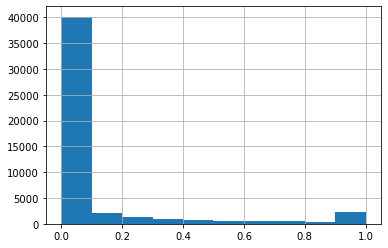

In [10]:
inference["probability_modified_GIS_MCF7_directRNA_Rep3-Run1"].hist()

<AxesSubplot:>

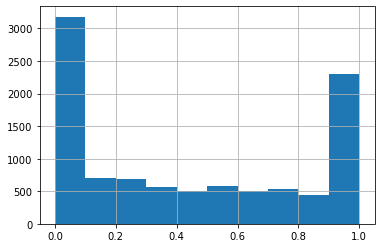

In [9]:
get_modified_positions(inference, 0.5)["probability_modified_GIS_MCF7_directRNA_Rep3-Run1"].hist()

In [7]:
get_modified_positions(inference, 0.9)

,transcript_id,transcript_position,n_reads_GIS_A549_directRNA_Rep5-Run1,probability_modified_GIS_A549_directRNA_Rep5-Run1,n_reads_GIS_A549_directRNA_Rep6-Run1,probability_modified_GIS_A549_directRNA_Rep6-Run1,n_reads_GIS_Hct116_directRNA_Rep2-Run1,probability_modified_GIS_Hct116_directRNA_Rep2-Run1,n_reads_GIS_Hct116_directRNA_Rep2-Run4,probability_modified_GIS_Hct116_directRNA_Rep2-Run4,...,n_reads_GIS_K562_directRNA_Rep4-Run1,probability_modified_GIS_K562_directRNA_Rep4-Run1,n_reads_GIS_K562_directRNA_Rep5-Run1,probability_modified_GIS_K562_directRNA_Rep5-Run1,n_reads_GIS_K562_directRNA_Rep6-Run1,probability_modified_GIS_K562_directRNA_Rep6-Run1,n_reads_GIS_MCF7_directRNA_Rep3-Run1,probability_modified_GIS_MCF7_directRNA_Rep3-Run1,n_reads_GIS_MCF7_directRNA_Rep4-Run1,probability_modified_GIS_MCF7_directRNA_Rep4-Run1
12,ENST00000000233,665,52.0,0.496019,92.0,0.671179,205.0,0.997386,195.0,0.903953,...,121.0,0.681436,95.0,0.998670,132.0,0.868489,293.0,0.829568,240.0,0.755849
16,ENST00000000233,765,52.0,0.593954,101.0,0.403313,201.0,0.461334,201.0,0.799943,...,123.0,0.459068,101.0,0.906288,134.0,0.890273,316.0,0.003469,243.0,0.199829
17,ENST00000000233,913,40.0,0.833097,94.0,0.754379,179.0,0.757797,195.0,0.824847,...,109.0,0.641457,95.0,0.746030,127.0,0.999073,276.0,0.574189,239.0,0.472551
39,ENST00000000412,1986,24.0,0.105641,84.0,0.009812,68.0,0.699469,46.0,0.953971,...,24.0,0.650793,NaN,NaN,NaN,NaN,25.0,0.000121,53.0,0.000132
44,ENST00000000412,2440,20.0,0.999999,79.0,1.000000,60.0,1.000000,43.0,1.000000,...,20.0,1.000000,NaN,NaN,NaN,NaN,29.0,1.000000,47.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77775,ENST00000641834,1093,23.0,1.000000,71.0,0.998228,73.0,0.999999,63.0,0.999997,...,27.0,0.999325,32.0,0.999994,31.0,0.999987,33.0,1.000000,66.0,0.980516
77776,ENST00000641834,1193,25.0,0.416939,69.0,0.025601,69.0,0.247254,59.0,0.036653,...,31.0,0.000691,30.0,0.041744,33.0,0.929914,34.0,0.002531,74.0,0.362225
77778,ENST00000641834,1255,22.0,1.000000,72.0,1.000000,70.0,1.000000,62.0,1.000000,...,26.0,1.000000,33.0,1.000000,35.0,1.000000,36.0,1.000000,65.0,1.000000
77779,ENST00000641834,1348,22.0,1.000000,74.0,0.999977,73.0,1.000000,63.0,0.999999,...,28.0,1.000000,33.0,1.000000,36.0,0.999963,36.0,1.000000,73.0,0.999995


In [ ]:
tx_ref = create_tx_ref(inference["transcript_id"].unique())

  0%|          | 0/3652 [00:00<?, ?it/s]

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /data03/christopher/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa.pickle


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_rel_positions(ax, get_modified_positions(inference, 0.9), tx_ref, label="Threshold:0.9")
plot_rel_positions(ax, get_modified_positions(inference, 0.5), tx_ref, label="Threshold:0.5")
plot_rel_positions(ax, get_modified_positions(inference, 0), tx_ref, label="Threshold:0")
plt.legend()
# plot_rel_positions(ax, m6ace, tx_ref, label="m6ACE")


In [ ]:
fig.savefig("/home/christopher/metagene_plots.svg",format="svg")


In [24]:
df = inference.merge(tx_ref,how='inner',on='transcript_id')
df['isin_5utr'] = df['transcript_position'] < df['end_5utr']
df['isin_cds'] = (~df['isin_5utr']) & (df['transcript_position'] < df['end_cds'])
df['isin_3utr'] = (~df['isin_5utr']) & (~df['isin_cds']) #& (df['tx_pos'] < df['end_tx'])
len_cds = df['end_cds']-df['end_5utr']
len_3utr = df['end_tx']-df['end_cds']

assert (len_cds > 0).all()
assert (len_3utr > 0).all()

rel_len_5utr = df['isin_5utr']*(df['transcript_position']/df['end_5utr'])
rel_len_cds = df['isin_cds']*((df['transcript_position']-df['end_5utr'])/len_cds)
rel_len_3utr = df['isin_3utr']*((df['transcript_position']-df['end_cds'])/len_3utr)

df['rel_5utr'] = rel_len_5utr
df['rel_cds'] = rel_len_cds
df['rel_3utr'] = rel_len_3utr

In [26]:
df.to_csv("/home/christopher/metagene_table.csv", index=False)

/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


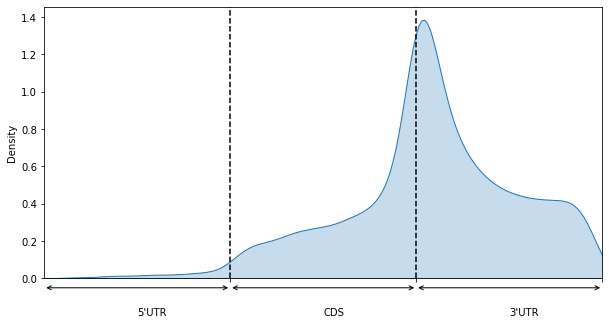

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_, df, rel_len_5utr, rel_len_cds, rel_len_3utr = plot_rel_positions(ax, inference[inference["probability_modified"] >= 0.9], tx_ref, label="m6ANet_threshold:0.9")


In [28]:
inference

,transcript_id,transcript_position,n_reads,probability_modified
0,ENST00000389680,103,264,5.415571e-01
1,ENST00000389680,166,861,3.537386e-07
2,ENST00000389680,179,111,7.585717e-15
3,ENST00000389680,204,896,3.120168e-10
4,ENST00000389680,218,861,2.514916e-13
...,...,...,...,...
259530,ENST00000457540,106,24,1.578960e-09
259531,ENST00000457540,132,27,1.089282e-10
259532,ENST00000457540,145,24,1.476037e-11
259533,ENST00000457540,245,23,9.999941e-01


In [27]:
inference.transcript_id.unique()

array(['ENST00000389680', 'ENST00000387347', 'ENST00000387460', ...,
       'ENST00000427426', 'ENST00000414273', 'ENST00000457540'],
      dtype=object)

In [24]:
[x for x in inference[inference["probability_modified"] >= 0].transcript_id.unique() if 'R' in x]

[]